<a href="https://colab.research.google.com/github/ravinasha/mac/blob/main/half_body_to_full_body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras as keras
import numpy as np
import os

In [ ]:
def build_generator(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    down1 = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    down2 = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(down1)
    down3 = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(down2)
    down4 = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(down3)

    # Decoder
    up1 = layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(down4)
    up1 = layers.Concatenate()([up1, down3])
    up2 = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(up1)
    up2 = layers.Concatenate()([up2, down2])
    up3 = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(up2)
    up3 = layers.Concatenate()([up3, down1])

    # Output
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up3)

    generator = keras.Model(inputs, outputs)
    return generator

In [ ]:

input_shape = (256, 256, 6)
def build_discriminator(input_shape):
    input_image = keras.Input(shape=input_shape)
    generated_image = keras.Input(shape=input_shape)

    # Concatenate input image and generated image
    concatenated = layers.Concatenate()([input_image, generated_image])

    # Encoder
    down1 = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(concatenated)
    down2 = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(down1)
    down3 = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(down2)
    down4 = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(down3)

    # Output
    outputs = layers.Conv2D(1, 4, strides=1, padding='same')(down4)

    discriminator = keras.Model(inputs=[input_image, generated_image], outputs=outputs)
    return discriminator


In [ ]:
def build_pix2pix(generator, discriminator):
    pix2pix_model = keras.Sequential()
    pix2pix_model.add(generator)
    pix2pix_model.add(discriminator)
    return pix2pix_model


In [ ]:
def generator_loss(fake_output, target_output, generated_output):
    gan_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target_output - generated_output))
    total_loss = gan_loss + (lambda_l1 * l1_loss)
    return total_loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
input_shape = (256, 256, 3)
batch_size = 3
epochs = 700
lambda_l1 = 120


In [ ]:
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image

In [ ]:
def preprocess_dataset(input_folder, target_folder):
    input_files = sorted(os.listdir(input_folder))
    target_files = sorted(os.listdir(target_folder))

    input_paths = [os.path.join(input_folder, filename) for filename in input_files]
    target_paths = [os.path.join(target_folder, filename) for filename in target_files]

    dataset = tf.data.Dataset.from_tensor_slices((input_paths, target_paths))
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:

def load_image_pair(input_path, target_path):
    input_image = load_image(input_path)
    target_image = load_image(target_path)
    return input_image, target_image


In [ ]:
input_folder = "/content/train1"                # upload ytrain and test dataset
target_folder = "/content/train2"


In [ ]:
train_dataset = preprocess_datasaet(input_folder, target_folder)

In [ ]:
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)

In [ ]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
#@title
@tf.function
def train_step(input_image, target_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(input_image, training=True)

        # Calculate discriminator loss
        real_output = discriminator([input_image, target_image], training=True)
        fake_output = discriminator([input_image, generated_images], training=True)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Calculate generator loss
        gen_loss = generator_loss(fake_output, target_image, generated_images)

    # Update the generator and discriminator variables
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [ ]:
for epoch in range(epochs):
    for input_image, target_image in train_dataset:
        train_step(input_image, target_image)

In [ ]:
generator.save_weights('/content/generator')                        # make a generator and discriminator folder
discriminator.save_weights('/content/discriminator')


In [ ]:
# Compile the models
generator.compile(optimizer=generator_optimizer, loss=generator_loss, metrics=['accuracy'])
discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss, metrics=['accuracy'])


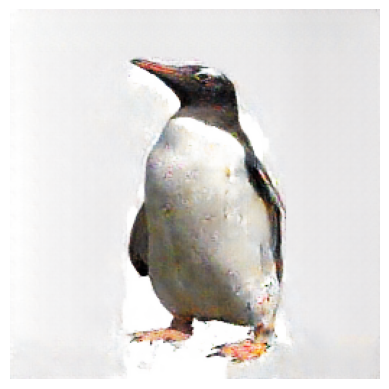

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Load the generator model
input_shape = (256, 256, 3)
generator = build_generator(input_shape)
generator.load_weights('/content/generator')

# Prepare input for generating the image
input_image = load_image('/content/1 (1).png')
input_image = tf.expand_dims(input_image, axis=0)

# Generate the output image
generated_image = generator(input_image, training=False)
generated_image = (generated_image + 1.0) * 0.5  # Denormalize the image

# Convert the generated image to NumPy array
generated_image = generated_image.numpy()[0]

# Display the generated image
plt.imshow(generated_image)
plt.axis('off')
plt.show()
